In [21]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('Apple Stock Data.csv')

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,111.389999,111.440002,107.349998,109.330002,101.528191,53204600
1,2015-01-05,108.290001,108.650002,105.410004,106.250000,98.667984,64285500
2,2015-01-06,106.540001,107.430000,104.629997,106.260002,98.677261,65797100
3,2015-01-07,107.199997,108.199997,106.699997,107.750000,100.060936,40105900
4,2015-01-08,109.230003,112.150002,108.699997,111.889999,103.905510,59364500


In [23]:

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM



#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:863,:]
valid = dataset[863:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

C:\Users\Jackson\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/5
 - 50s - loss: 0.0025
Epoch 2/5
 - 47s - loss: 9.2963e-04
Epoch 3/5
 - 45s - loss: 6.3269e-04
Epoch 4/5
 - 45s - loss: 4.9849e-04
Epoch 5/5
 - 47s - loss: 4.3383e-04


In [24]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

4.598416854912086

C:\Users\Jackson\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


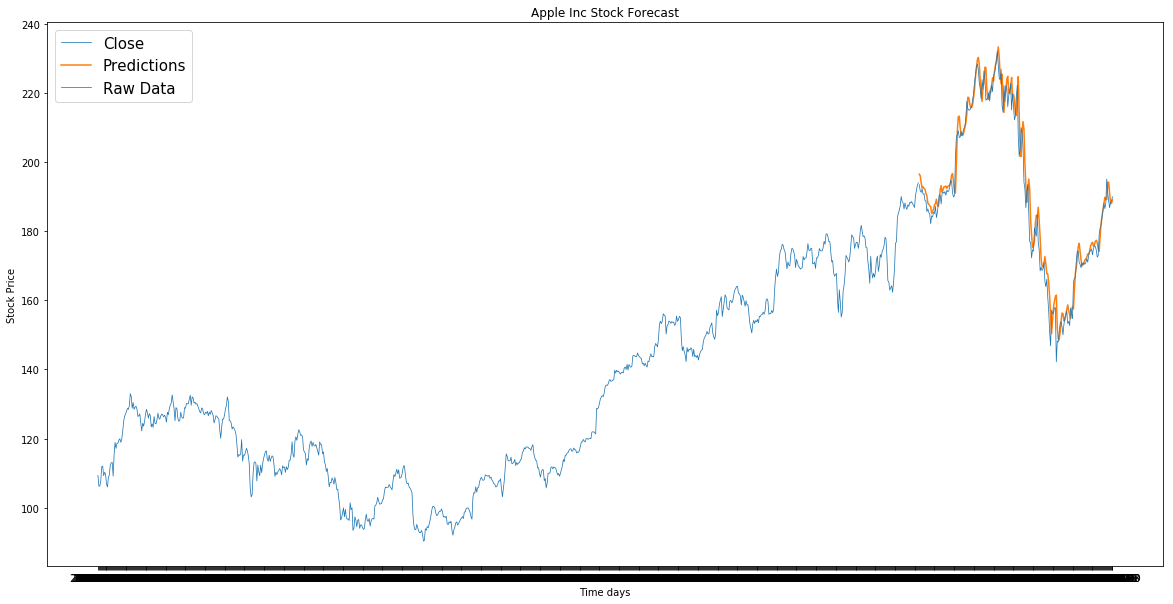

In [28]:
#for plotting
t = np.arange(0,1067,1)

train = new_data[:863]
valid = new_data[863:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], "#1f77b4", linewidth = 0.75)
plt.plot(valid['Predictions'], "#ff7f0e", Label = "Prediction")
plt.plot(valid['Close'], "#1f77b4", linewidth = 0.75, label = "Raw Data")
plt.legend(loc = 2,prop = {"size": 15})
plt.title("Apple Inc Stock Forecast" )
plt.ylabel("Stock Price")
plt.xlabel("Time days")
plt.show()